In [1]:
import numpy as np
import h5py
import time
import scipy
import matplotlib.pyplot as plt
from PIL import Image
from scipy import ndimage
from dnn_app_utils_v3 import *

%matplotlib inline
plt.rcParams['figure.figsize'] = (5.0, 4.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

%load_ext autoreload
%autoreload 2

np.random.seed(1)

### Helper functions

In [2]:
# SOME HELPER FUNCTIONS
def sigmoid(Z):
    """
    Arguments:
    Z -- numpy array of any shape
    Returns:
    A -- output of sigmoid(z), same shape as Z
    """
    
    A = 1/(1+np.exp(-Z))
    cache = Z
    return A, cache

def relu(Z):
    """
    Arguments:
    Z -- Output of the linear layer, of any shape
    Returns:
    A -- Post-activation parameter, of the same shape as Z
    """
    
    A = np.maximum(0,Z)
    
    assert(A.shape == Z.shape)
    cache = Z 

    return A, cache

def relu_backward(dA, cache):
    """
    Implement the backward propagation for a single RELU unit.
    Arguments:
    dA -- post-activation gradient, of any shape
    cache -- 'Z' where we store for computing backward propagation efficiently

    Returns:
    dZ -- Gradient of the cost with respect to Z
    """
    
    Z = cache
    dZ = np.array(dA, copy=True) # just converting dz to a correct object.
    
    # When z <= 0, we should set dz to 0 as well. 
    dZ[Z <= 0] = 0
    
    assert (dZ.shape == Z.shape)
    
    return dZ

def sigmoid_backward(dA, cache):
    """
    Implement the backward propagation for a single SIGMOID unit.
    Arguments:
    dA -- post-activation gradient, of any shape
    cache -- 'Z' where we store for computing backward propagation efficiently

    Returns:
    dZ -- Gradient of the cost with respect to Z
    """
    
    Z = cache

    s = 1/(1+np.exp(-Z))
    dZ = dA * s * (1-s)
    assert (dZ.shape == Z.shape)
    
    return dZ

def predict(X, y, parameters):
    """ This function is used to predict the results of a  L-layer neural network.
    Arguments:
    X -- data set of examples 
    parameters -- parameters of the trained model
    
    Returns:
    p -- predictions for the given dataset X
    """
    m = X.shape[1]
    n = len(parameters) // 2 # number of layers in the neural network
    p = np.zeros((1,m))
    
    # Forward propagation
    probas, caches = L_model_forward(X, parameters)

    # convert probas to 0/1 predictions
    for i in range(0, probas.shape[1]):
        if probas[0,i] > 0.5:
            p[0,i] = 1
        else:
            p[0,i] = 0
    print("Accuracy: "  + str(np.sum((p == y)/m)))
        
    return p

### Initializing parameters

In [3]:
def initialize_parameters(n_x, n_h, n_y): # for two layered neural network
    """
    Argument:
    n_x -- size of the input layer
    n_h -- size of the hidden layer
    n_y -- size of the output layer
    
    Returns:
    parameters -- python dictionary containing your parameters:
                    W1 -- weight matrix of shape (n_h, n_x)
                    b1 -- bias vector of shape (n_h, 1)
                    W2 -- weight matrix of shape (n_y, n_h)
                    b2 -- bias vector of shape (n_y, 1)
    """
    np.random.seed(69)

    W1 = np.random.randn(n_h, n_x) * 0.01  # for random initialization
    b1 = np.zeros((n_h,1))
    W2 = np.random.randn(n_y, n_h) * 0.01 
    b2 = np.zeros((n_y,1))

    parameters = {"W1" : W1,
                  "W2" : W2,
                  "b1" : b1,
                  "b2" : b2}
    return parameters
    
    

In [4]:
def initialize_parameters_deep(layer_dims): # for deep neural network with N layers
    """
    Arguments:
    layer_dims -- python array containing the dimensions of each layer in network
    Returns:
    parameters -- python dictionary containing your parameters "W1", "b1", ..., "WL", "bL":
                    Wl -- weight matrix of shape (layer_dims[l], layer_dims[l-1])
                    bl -- bias vector of shape (layer_dims[l], 1) """

    np.random.seed(3)
    parameters = {}
    L = len(layer_dims) # number of layers in the network

    for l in range(1, L):
        parameters['W' + str(l)] = np.random.randn(layer_dims[l],layer_dims[l-1]) * 0.01
        parameters['b' + str(l)] = np.zeros((layer_dims[l],1))
        
        assert(parameters["W" + str(l)].shape == (layer_dims[l], layer_dims[l - 1]))
        assert(parameters["b" + str(l)].shape == (layer_dims[l], 1))

        
    return parameters

### Forward propagation steps

In [5]:
def linear_forward(A, W, b):
    """  Implement the linear part of a layer's forward propagation.
    Arguments:
    A -- activations from previous layer (or input data): (size of previous layer, number of examples)
    W -- weights matrix: numpy array of shape (size of current layer, size of previous layer)
    b -- bias vector, numpy array of shape (size of the current layer, 1)
    
    Returns:
    Z -- the input of the activation function, also called pre-activation parameter 
    """
    
    Z = np.dot(W,A) + b
    cache = (A, W, b)
    
    return Z, cache 

In [6]:
def linear_activation_forward(A_prev, W, b, activation):
    """ Implement the forward propagation for the LINEAR->ACTIVATION layer
    Arguments:
    A_prev -- activations from previous layer (or input data): (size of previous layer, number of examples)
    W -- weights matrix: numpy array of shape (size of current layer, size of previous layer)
    b -- bias vector, numpy array of shape (size of the current layer, 1)
    activation -- the activation to be used in this layer, stored as a text string: "sigmoid" or "relu"

    Returns:
    A -- the output of the activation function, also called the post-activation value 
    cache -- a python tuple containing "linear_cache" and "activation_cache";
             stored for computing the backward pass efficiently """

    if activation == "sigmoid":
        Z, linear_cache = linear_forward(A_prev, W, b)
        A, activation_cache = sigmoid(Z)

    if activation == "relu":
        Z, linear_cache = linear_forward(A_prev, W, b)
        A, activation_cache = relu(Z)

    cache = (linear_cache, activation_cache)

    return A, cache

### creating L-layered model [LINEAR->RELU]*(L-1) layers + Output layer

In [7]:
def L_model_forward(X, parameters):
    """ Implement forward propagation for the [LINEAR->RELU]*(L-1)->LINEAR->SIGMOID computation
    Arguments:
    X -- data, numpy array of shape (input size, number of examples)
    parameters -- output of initialize_parameters_deep()
    
    Returns:
    AL -- activation value from the output (last) layer
    caches -- list of caches containing: every cache of linear_activation_forward() (there are L of them, indexed from 0 to L-1) """

    caches = []
    A = X
    L = len(parameters) // 2  # number of layers in the neural network
    
    # Implement [LINEAR -> RELU]*(L-1). Add "cache" to the "caches" list.
    for l in range(1, L): 
        A_prev = A 
        A, cache = linear_activation_forward(A_prev, parameters["W" + str(l)], parameters["b" + str(l)], "relu")
        caches.append(cache)
    
    # Implement LINEAR -> SIGMOID. Add "cache" to the "caches" list.
    AL, cache = linear_activation_forward(A, parameters['W' + str(L)], parameters['b' + str(L)], "sigmoid")
    caches.append(cache)
          
    return AL, caches

### Cost Function
Computing the cross-entropy cost $J$, using the following formula: $$-\frac{1}{m} \sum\limits_{i = 1}^{m} (y^{(i)}\log\left(a^{[L] (i)}\right) + (1-y^{(i)})\log\left(1- a^{[L](i)}\right)) \tag{7}$$


In [8]:
def compute_cost(AL, Y):
    """
    Arguments:
    AL -- probability vector corresponding to label predictions, shape (1, number of examples)
    Y -- true "label" vector (for example: containing 0 if non-cat, 1 if cat), shape (1, number of examples)
    Returns:
    cost -- cross-entropy cost
    """
    
    m = Y.shape[1] # no. of training examples
    
    cost = (-1/m) * (np.dot(Y,np.log(AL).T) + np.dot((1-Y),np.log(1-AL).T))
    cost = np.squeeze(cost)

    return cost

### Back propagation

In [9]:
def linear_backward(dZ, cache):
    """
    Implement the linear portion of backward propagation for a single layer (layer l)

    Arguments:
    dZ -- Gradient of the cost with respect to the linear output (of current layer l)
    cache -- tuple of values (A_prev, W, b) coming from the forward propagation in the current layer
    
    Returns:
    dA_prev -- Gradient of the cost with respect to the activation (of the previous layer l-1), same shape as A_prev
    dW -- Gradient of the cost with respect to W (current layer l), same shape as W
    db -- Gradient of the cost with respect to b (current layer l), same shape as b """

    A_prev, W, b = cache
    m = A_prev.shape[1]

    dW = (1/m) * np.dot(dZ,A_prev.T)
    db = (1/m) * np.sum(dZ, axis=1, keepdims = True)
    dA_prev = np.dot(W.T,dZ)
    
    return dA_prev, dW, db

In [10]:
def linear_activation_backward(dA, cache, activation):
    """
    Implement the backward propagation for the LINEAR->ACTIVATION layer.
    Arguments:
    dA -- post-activation gradient for current layer l 
    cache -- tuple of values (linear_cache, activation_cache) we stored for computing backward propagation efficiently
    activation -- the activation to be used in this layer, stored as a text string: "sigmoid" or "relu"

    Returns:
    dA_prev -- Gradient of the cost with respect to the activation (of the previous layer l-1), same shape as A_prev
    dW -- Gradient of the cost with respect to W (current layer l), same shape as W
    db -- Gradient of the cost with respect to b (current layer l), same shape as b
    """
    linear_cache, activation_cache = cache
    
    if activation == "relu":
        dZ = relu_backward(dA, activation_cache)
        dA_prev, dW, db = linear_backward(dZ, linear_cache)
        
    elif activation == "sigmoid":
        dZ = sigmoid_backward(dA, activation_cache)
        dA_prev, dW, db = linear_backward(dZ, linear_cache)

    return dA_prev, dW, db

### L-layered Model backwards

In [11]:
def L_model_backward(AL, Y, caches):
    """
    Implement the backward propagation for the [LINEAR->RELU] * (L-1) -> LINEAR -> SIGMOID group
    
    Arguments:
    AL -- probability vector, output of the forward propagation (L_model_forward())
    Y -- true "label" vector (containing 0 if non-cat, 1 if cat)
    caches -- list of caches containing:
                every cache of linear_activation_forward() with "relu" (it's caches[l], for l in range(L-1) i.e l = 0...L-2)
                the cache of linear_activation_forward() with "sigmoid" (it's caches[L-1])
    Returns:
    grads -- A dictionary with the gradients
             grads["dA" + str(l)] = ... 
             grads["dW" + str(l)] = ...
             grads["db" + str(l)] = ... 
    """
    grads = {}
    L = len(caches) # the number of layers
    m = AL.shape[1]
    Y = Y.reshape(AL.shape)
    
    # Initializing the backpropagation
    dAL = - (np.divide(Y, AL) - np.divide(1 - Y, 1 - AL))  # partial derivation of cost w.r.t AL
    
    # Lth layer (SIGMOID -> LINEAR) gradients. 
    current_cache = caches[L-1]   #last layer
    dA_prev_temp, dW_temp, db_temp = linear_activation_backward(dAL, caches[L-1], "sigmoid")
    grads["dA" + str(L-1)] = dA_prev_temp
    grads["dW" + str(L)] = dW_temp
    grads["db" + str(L)] = db_temp
    
    grads["dA" + str(L-1)], grads["dW" + str(L)], grads["db" + str(L)] = linear_activation_backward(dAL, current_cache, "sigmoid")
    
    # Loop from l=L-2 to l=0
    for l in reversed(range(L-1)):
        current_cache = caches[l]
        dA_prev_temp, dW_temp, db_temp = linear_activation_backward(dA_prev_temp, current_cache, "relu")
        grads["dA" + str(l)] = dA_prev_temp
        grads["dW" + str(l + 1)] = dW_temp
        grads["db" + str(l + 1)] = db_temp

    return grads

### Updating parameteres

In [12]:
def update_parameters(params, grads, learning_rate):
    """ Update parameters using gradient descent
    Arguments:
    params -- python dictionary containing your parameters 
    grads -- python dictionary containing your gradients, output of L_model_backward
    
    Returns:
    parameters -- python dictionary containing your updated parameters 
                  parameters["W" + str(l)] = ... 
                  parameters["b" + str(l)] = ...
    """
    parameters = params.copy()
    L = len(parameters) // 2 # number of layers in the neural network

    for l in range(L):
        parameters["W" + str(l+1)] = parameters["W" + str(l + 1)] - learning_rate * grads["dW" + str(l+1)]
        parameters["b" + str(l+1)] = parameters["b" + str(l+1)] - learning_rate * grads["db" + str(l+1)]
         
    return parameters

### Loading the Dataset

In [3]:
def load_data(): 
    train_dataset = h5py.File('C:\ML workspace\DEEP_LEARNING\cat-vs-noncat/train_catvnoncat.h5', "r")
    train_set_x_orig = np.array(train_dataset["train_set_x"][:]) # your train set features
    train_set_y_orig = np.array(train_dataset["train_set_y"][:]) # your train set labels

    test_dataset = h5py.File('C:\ML workspace\DEEP_LEARNING\cat-vs-noncat/test_catvnoncat.h5', "r")
    test_set_x_orig = np.array(test_dataset["test_set_x"][:]) # your test set features
    test_set_y_orig = np.array(test_dataset["test_set_y"][:]) # your test set labels

    classes = np.array(test_dataset["list_classes"][:]) # the list of classes
    
    train_set_y_orig = train_set_y_orig.reshape((1, train_set_y_orig.shape[0]))
    test_set_y_orig = test_set_y_orig.reshape((1, test_set_y_orig.shape[0]))
    
    return train_set_x_orig, train_set_y_orig, test_set_x_orig, test_set_y_orig, classes


<>:2: SyntaxWarning: invalid escape sequence '\M'
<>:6: SyntaxWarning: invalid escape sequence '\M'
<>:2: SyntaxWarning: invalid escape sequence '\M'
<>:6: SyntaxWarning: invalid escape sequence '\M'
C:\Users\NEXGEN\AppData\Local\Temp\ipykernel_7936\2968816805.py:2: SyntaxWarning: invalid escape sequence '\M'
  train_dataset = h5py.File('C:\ML workspace\DEEP_LEARNING\cat-vs-noncat/train_catvnoncat.h5', "r")
C:\Users\NEXGEN\AppData\Local\Temp\ipykernel_7936\2968816805.py:6: SyntaxWarning: invalid escape sequence '\M'
  test_dataset = h5py.File('C:\ML workspace\DEEP_LEARNING\cat-vs-noncat/test_catvnoncat.h5', "r")


In [4]:
train_x_orig, train_y, test_x_orig, test_y, classes = load_data()

y = 1. It's a cat picture.


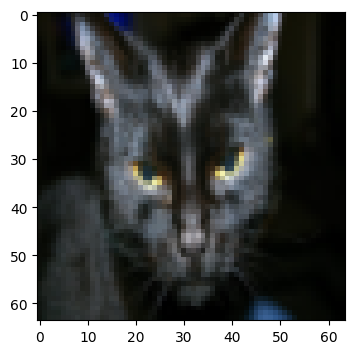

In [5]:
# Example of a picture
index = 25
plt.imshow(train_x_orig[index])
print ("y = " + str(train_y[0,index]) + ". It's a " + classes[train_y[0,index]].decode("utf-8") +  " picture.")

In [6]:
# Exploring  dataset 
m_train = train_x_orig.shape[0]
num_px = train_x_orig.shape[1]
m_test = test_x_orig.shape[0]

print ("Number of training examples: " + str(m_train))
print ("Number of testing examples: " + str(m_test))
print ("Each image is of size: (" + str(num_px) + ", " + str(num_px) + ", 3)")
print ("train_x_orig shape: " + str(train_x_orig.shape))
print ("train_y shape: " + str(train_y.shape))
print ("test_x_orig shape: " + str(test_x_orig.shape))
print ("test_y shape: " + str(test_y.shape))

Number of training examples: 209
Number of testing examples: 50
Each image is of size: (64, 64, 3)
train_x_orig shape: (209, 64, 64, 3)
train_y shape: (1, 209)
test_x_orig shape: (50, 64, 64, 3)
test_y shape: (1, 50)


### Reshaping the dataset

In [7]:
# Reshape the training and test examples 
train_x_flatten = train_x_orig.reshape(train_x_orig.shape[0], -1).T   # The "-1" makes reshape flatten the remaining dimensions
test_x_flatten = test_x_orig.reshape(test_x_orig.shape[0], -1).T

# Standardize data to have feature values between 0 and 1.
train_x = train_x_flatten/255
test_x = test_x_flatten/255

print ("train_x's shape: " + str(train_x.shape))
print ("test_x's shape: " + str(test_x.shape))


train_x's shape: (12288, 209)
test_x's shape: (12288, 50)


## 2- layered Neural Nework: LINEAR->RELU -> LINEAR->SIGMOID

In [18]:
### CONSTANTS DEFINING THE MODEL 
n_x = 12288 # num_px * num_px * 3 (the input image is 64x64x3) 
n_h = 7 # hidden layer with 7 hidden units
n_y = 1 # output layer
layers_dims = (n_x, n_h, n_y)

In [19]:
def two_layer_model(X, Y, layers_dims, learning_rate = 0.0075, num_iterations = 3000, print_cost=False):
    """ Implements a two-layer neural network: LINEAR->RELU->LINEAR->SIGMOID.

    Arguments:
    X -- input data, of shape (n_x, number of examples)
    Y -- true "label" vector (containing 1 if cat, 0 if non-cat), of shape (1, number of examples)
    layers_dims -- dimensions of the layers (n_x, n_h, n_y)
    num_iterations -- number of iterations of the optimization loop
    learning_rate -- learning rate of the gradient descent update rule
    print_cost -- If set to True, this will print the cost every 100 iterations 
    
    Returns:
    parameters -- a dictionary containing W1, W2, b1, and b2
    """
    
    np.random.seed(69)
    grads = {}
    costs = []     # to keep track of the cost
    m = X.shape[1]  # number of examples
    (n_x, n_h, n_y) = layers_dims

    # initializing parameters
    parameters = initialize_parameters(n_x, n_h, n_y) 
 
    
    # Getting W1, b1, W2 and b2 from the dictionary parameters.
    W1 = parameters["W1"]
    b1 = parameters["b1"]
    W2 = parameters["W2"]
    b2 = parameters["b2"]
    
    # Looping (gradient descent)
    for i in range(0, num_iterations):
        A1, cache1 = linear_activation_forward(X, W1, b1, activation="relu")
        A2, cache2 = linear_activation_forward(A1, W2, b2, activation="sigmoid")

        # Compute cost
        cost = compute_cost(A2, Y)
        
        # Initializing backward propagation
        dA2 = - (np.divide(Y, A2) - np.divide(1 - Y, 1 - A2))
        
        # Backward propagation. 
        dA1, dW2, db2 = linear_activation_backward(dA2, cache2, activation="sigmoid")
        dA0, dW1, db1 = linear_activation_backward(dA1, cache1, activation="relu")
        
        # Set grads['dWl'] to dW1, grads['db1'] to db1, grads['dW2'] to dW2, grads['db2'] to db2
        grads['dW1'] = dW1
        grads['db1'] = db1
        grads['dW2'] = dW2
        grads['db2'] = db2
        
        # Updating parameters.
        parameters = update_parameters(parameters, grads, learning_rate)

        # Retrieve W1, b1, W2, b2 from parameters
        W1 = parameters["W1"]
        b1 = parameters["b1"]
        W2 = parameters["W2"]
        b2 = parameters["b2"]
        
        # Print the cost every 100 training examples
        if print_cost and i % 100 == 0:
            print("Cost after iteration {}: {}".format(i, np.squeeze(cost)))
        if print_cost and i % 100 == 0:
            costs.append(cost)
       

    plt.plot(np.squeeze(costs))
    plt.ylabel('cost')
    plt.xlabel('iterations (per hundreds)')
    plt.title("Learning rate =" + str(learning_rate))
    plt.show()
    
    return parameters

Cost after iteration 0: 0.6953665359564805
Cost after iteration 100: 0.6470630113930143
Cost after iteration 200: 0.6339222163128612
Cost after iteration 300: 0.6045289403822286
Cost after iteration 400: 0.5620615141076988
Cost after iteration 500: 0.517704485211332
Cost after iteration 600: 0.4729513804717357
Cost after iteration 700: 0.4136290240598699
Cost after iteration 800: 0.3783105771119923
Cost after iteration 900: 0.3601811445274405
Cost after iteration 1000: 0.34355556474342336
Cost after iteration 1100: 0.30528451496250586
Cost after iteration 1200: 0.31315656586370694
Cost after iteration 1300: 0.1717628189074341
Cost after iteration 1400: 0.15089516927897045
Cost after iteration 1500: 0.1251020895835265
Cost after iteration 1600: 0.10745328259040644
Cost after iteration 1700: 0.09262607267695948
Cost after iteration 1800: 0.0816602681218991
Cost after iteration 1900: 0.06770723711945544
Cost after iteration 2000: 0.0591196123307421
Cost after iteration 2100: 0.05157490306

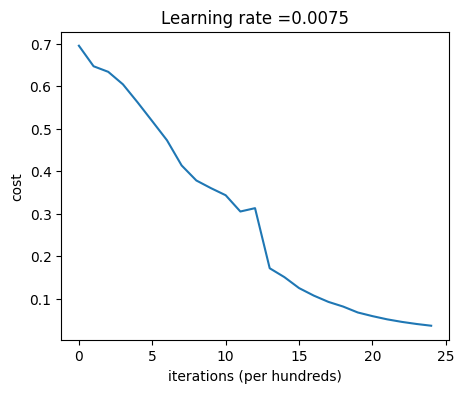

In [20]:
parameters = two_layer_model(train_x, train_y, layers_dims = (n_x, n_h, n_y), num_iterations = 2500, print_cost=True)

## Predictions of 2 -Layered Neural network

In [31]:
#predictions on training data
pred_train = predict(train_x, train_y, parameters) # using the helper function predict

Accuracy: 0.9043062200956936


In [29]:
# prediction on test data
pred_train = predict(test_x, test_y, parameters)

Accuracy: 0.78


## L-layered Neural network

In [8]:
### CONSTANTS 
layers_dims = [12288, 20, 7, 5, 1] #  4-layer model( 3 hidden layers + 1 output layer)

In [9]:
def L_layer_model(X, Y, layers_dims, learning_rate = 0.009, num_iterations = 2500, print_cost=False):#lr was 0.009
    """Implements a L-layer neural network: [LINEAR->RELU]*(L-1)->LINEAR->SIGMOID.
    
    Arguments:
    X -- data, numpy array of shape (num_px * num_px * 3, number of examples)
    Y -- true "label" vector (containing 0 if cat, 1 if non-cat), of shape (1, number of examples)
    layers_dims -- list containing the input size and each layer size, of length (number of layers + 1).
    learning_rate -- learning rate of the gradient descent update rule
    num_iterations -- number of iterations of the optimization loop
    print_cost -- if True, it prints the cost every 100 steps
    
    Returns:
    parameters -- parameters learnt by the model. They can then be used to predict.
    """

    np.random.seed(69)
    costs = []  # keep track of cost
    
    # Parameters initialization.
    parameters = initialize_parameters_deep(layers_dims)
    
    # Loop (gradient descent)
    for i in range(0, num_iterations):

        # Forward propagation: [LINEAR -> RELU]*(L-1) -> LINEAR -> SIGMOID.
        AL, caches = L_model_forward(X, parameters)

        # Compute cost.
        cost = compute_cost(AL, Y)
    
        # Backward propagation.
        grads = L_model_backward(AL, Y, caches)
 
        # Update parameters.
        parameters = update_parameters(parameters, grads, learning_rate)
                
        # Print the cost every 100 training example
        if print_cost and i % 100 == 0:
            print ("Cost after iteration %i: %f" %(i, cost))
        if print_cost and i % 100 == 0:
            costs.append(cost)
            
    # plot the cost
    plt.plot(np.squeeze(costs))
    plt.ylabel('cost')
    plt.xlabel('iterations (per hundreds)')
    plt.title("Learning rate =" + str(learning_rate))
    plt.show()
    
    return parameters

Cost after iteration 0: 0.771749
Cost after iteration 100: 0.668643
Cost after iteration 200: 0.644902
Cost after iteration 300: 0.585219
Cost after iteration 400: 0.521544
Cost after iteration 500: 0.490371
Cost after iteration 600: 0.388918
Cost after iteration 700: 0.366900
Cost after iteration 800: 0.398332
Cost after iteration 900: 0.351117
Cost after iteration 1000: 0.250425
Cost after iteration 1100: 0.167711
Cost after iteration 1200: 0.143310
Cost after iteration 1300: 0.125508
Cost after iteration 1400: 0.111445
Cost after iteration 1500: 0.100332
Cost after iteration 1600: 0.091003
Cost after iteration 1700: 0.082590
Cost after iteration 1800: 0.075972
Cost after iteration 1900: 0.071135
Cost after iteration 2000: 0.065827
Cost after iteration 2100: 0.063602
Cost after iteration 2200: 0.057674
Cost after iteration 2300: 0.054198
Cost after iteration 2400: 0.051434


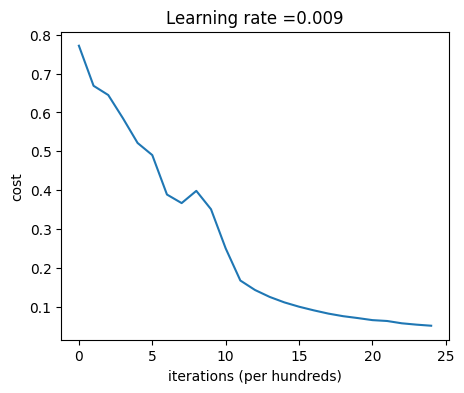

In [10]:
parameters = L_layer_model(train_x, train_y, layers_dims, num_iterations = 2500, print_cost = True)

In [11]:
pred_train = predict(train_x, train_y, parameters)

Accuracy: 0.9952153110047844


In [12]:
pred_test = predict(test_x, test_y, parameters)

Accuracy: 0.8


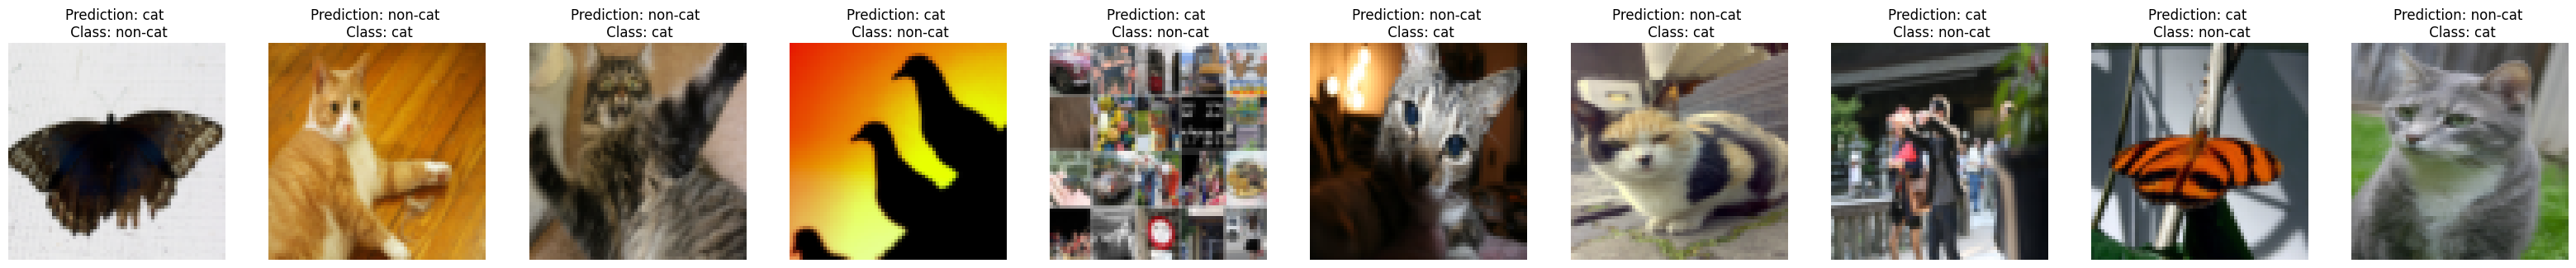

In [13]:
print_mislabeled_images(classes, test_x, test_y, pred_test) # mislabeled examples on test dataset

**A few types of images the model tends to do poorly on include:** 
- Cat body in an unusual position
- Cat appears against a background of a similar color
- Unusual cat color and species
- Camera Angle
- Brightness of the picture
- Scale variation (cat is very large or small in image) 

We have performed better on L-layered model with `train_accuracy` of `90%` and `test_accuracy` of `78%`.

This model was build using numpy only, it can be improved alot using different regularization techniques and convolution neural networks 